# Анализ тональности текста

*Паршина Анастасия, НИУ ВШЭ*

Сегодня мы посмотрим, как можно определить тональность текста, то есть понять, с какой вероятностью интересующий нас текст будет с положительным или же, наоборот, с негативным окрасом. Инструменты для работы с англоязычными текстами уже есть в знакомом нам модуле `textblob`, импортируем из него класс `TextBlob` и приступим к работе.

## Работа с англоязычными текстами

### Как определить тональность?

In [1]:
#!pip install textblob
from textblob import TextBlob

Рассмотрим слова `good`, `not good` и `not very good`, обратившись к атрибуту `.sentiment`. Такое обращение вернет нам кортеж, со значением `polarity` (то есть тональность) и значением `subjectivity` (субъективность). 

Значение тональности лежит на отрезке \[-1.0 до 1.0\], где -1.0 — высокая вероятность, что слово принимает негативную окраску (соответственно, крайне низкая вероятность, что здесь может быть положительная трактовка слова); а 1.0 — высокая вероятность, что слово принимает положительную окраску (соответственно, крайне низкая вероятность, что здесь может быть отрицательная трактовка слова).

Субъективность же может принимать значения на отрезке \[0.0 до 1.0\], где 0.0 — очень объективно, а 1.0 — крайне субъективно.

In [2]:
print(TextBlob("good").sentiment)
print(TextBlob("not good").sentiment)
print(TextBlob("very good").sentiment)
print(TextBlob("not very good").sentiment)

Sentiment(polarity=0.7, subjectivity=0.6000000000000001)
Sentiment(polarity=-0.35, subjectivity=0.6000000000000001)
Sentiment(polarity=0.9099999999999999, subjectivity=0.7800000000000001)
Sentiment(polarity=-0.26923076923076916, subjectivity=0.46153846153846156)


А теперь попробуем разобраться, почему у нас получились такие результаты. 

На самом деле, у каждого слова есть еще одна характеристика — `intensity`, которая нам не видна. Посмотреть на нее можно в [исходном файле](https://github.com/sloria/TextBlob/blob/eb08c120d364e908646731d60b4e4c6c1712ff63/textblob/en/en-sentiment.xml), который используется для анализа.

Посмотрим, какие данные есть для слов `good` и `very`:

| слово | polarity | subjectivity | intensity
|:-------------:|:-------------:|:-------------:|:-------------:|
| good | 0.7 | 0.4 | 1.0 |
| good | 0.7 | 0.8 | 1.0 |
| very | 0.2 | 0.3 | 1.3 |

Слово `good` действительно встречается в данных два раза. Первый раз оно упоминается как часть речи RB (Adverb), второй раз в качестве JJ (Adjective). Именно поэтому в первом примере, если обратить внимание на субъективность, то можно увидеть, что нам выдается среднее между 0.4 и 0.8.

Далее разбираемся с примером `not good`. Почему изменилась тональность, но не поменялась субъективность? Как таковое, слово `not` не влияет на субъективность, но домножает тональность на **-0.5**.

In [3]:
negative = -0.5
print(TextBlob("not good").polarity == negative * TextBlob("good").polarity)

True


Как в таком случае работает слово `very`? Оно усиливает как тональность, так и субъективность, домножая об значения на свою интенсивность. Если вдруг при таком домножени значение тональности получилось выше 1.0 или ниже -1.0, то выдается 1.0 и -1.0 соответственно. Аналогично для субъективность — если значение получилось выше 1.0, то выдается 1.0.

In [4]:
print(TextBlob("very good").polarity == 1.3 * TextBlob("good").polarity)
print(TextBlob("very good").subjectivity == 1.3 * TextBlob("good").subjectivity)

True
True


С примером `not very good` все еще интереснее. Слово `not` все также дает нам домножение на **-0.5**. И за отрицания у нас получается обратная интенсивность, то есть теперь мы не умножаем на нее, а делим.

In [5]:
print(TextBlob("not very good").polarity == negative * TextBlob("good").polarity / 1.3)
print(TextBlob("not very good").subjectivity == TextBlob("good").subjectivity / 1.3)

False
True


Слова, которые не имеют эмоциональную окраску, алгоритм не учитывает.

In [6]:
print(TextBlob("not very good").sentiment)
print(TextBlob("not very good lecture").sentiment)

Sentiment(polarity=-0.26923076923076916, subjectivity=0.46153846153846156)
Sentiment(polarity=-0.26923076923076916, subjectivity=0.46153846153846156)


Модулей и функций в них, которые бы определяли тональность текстов, несколько. Для разнообразия покажем вам еще один — VADER (Valence Aware Dictionary and sEntiment Reasoner), его чаще всего используют для анализа настоений в социльных сетях. Нам понадобится класс `SentimentIntensityAnalyzer()`.

In [7]:
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

В качестве примеров рассмотрим `very good` и `very good :)`.

In [8]:
vader = SentimentIntensityAnalyzer()

print(vader.polarity_scores('very good'))
print(vader.polarity_scores('very good :)'))

{'neg': 0.0, 'neu': 0.238, 'pos': 0.762, 'compound': 0.4927}
{'neg': 0.0, 'neu': 0.134, 'pos': 0.866, 'compound': 0.7559}


Давайте разберем, что же мы получили. На каждый текст выдается четыре значения — "neg", "neu", "pos" и "compound".

Первые три обозначают, насколько негативный, нейтральный или позитивный контекст имеет фраза. Суммарно эти три значения выдают на 1. 

Последнее же, "compound", аналогично тональности из класса `TextBlob` и может принимать значения от -1 (негативная окраска фразы) до 1 (позитивная окраска фразы). В нашем примере видно, что один только смайлик `:)` увеличил это значение на 0.2632.

С русскими словами, к сожалению, они не работают, однако в конце темы мы рассмотрим и вариант анализа тональности русскоязычных текстов.

In [9]:
print(TextBlob("хорошо").sentiment)
print(vader.polarity_scores('хорошо'))

Sentiment(polarity=0.0, subjectivity=0.0)
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


### Определение тональности комментариев

Сейчас нам потребуется загрузить данные в виде таблицы. С этим нам поможет модуль `pandas`. Импортируем его под псевдонимом `pd`.

In [10]:
import pandas as pd 

Данные, с которыми мы сегодня будем работать, представляют собой информацию (в том числе отзывы) о товарах, купленных на Amazon. С иточником данных можно ознакомиться [по ссылке](https://www.kaggle.com/code/sdxingaijing/topic-model-lda-algorithm/input). Данных там слишком много, поэтому для наших целей мы немного сократили их. Сам файл будет доступен в материалах курса.

Загрузить файл можно с помощью функции `read_csv()`. Чтобы сработала команда ниже, необходимо, чтобы файл лежал в одной папаке (имел одну директорию) с блокнотом, где мы сейчас работаем.

Используем метод `.head()` (выдает первые пять строк таблицы) и проверим, что данные корректно загрузились.

In [11]:
data = pd.read_csv('amazon_reviews.csv')
data.head()

,ProductId,UserId,ProfileName,Score,Summary,Text
0,B001717U9U,A34TQDJ94475AO,"Jay Endo ""Jay Endo""",2,Not worth the money,The potatos and hot dogs are really good.... I...
1,B001SAX0EE,AYFENUF5IEAZQ,ellamar,5,"Try it, you'll love it.",If you have never tried these Telma cubes in m...
2,B001ELL60W,A3DSWKQ2CR9H1G,yvonne,5,best waffel mix ever,My family loves this product. We have done ta...
3,B008114GDW,A1SLAL64ORLT41,Bonnie Muffin,5,Cinnamon nom nom noms,These taste exactly like cinnamon toast crunch...
4,B000EVNYQM,A2E2GGQGZOG4TD,"Wisdom ""seeker""",5,great cereal!,I discovered this cereal at a local market and...


Имеем следующие данные: 
    
+ `ProductId` — уникальный номер товара
+ `UserId` — уникальный номер человека, оставившего отзыв
+ `ProfileName` — имя человека / никнейм
+ `Score` — оценка товара
+ `Summary` — короткое описание отзыва
+ `Text` — текст отзыва

Всего в данных 28423 отзывов. Увидеть это можно с помощью атрибута `.shape` — нам будет выдан кортеж вида (строки, столбцы).

In [12]:
print(data.shape)

(28423, 6)


Давайте попробуем определить тональность отзывов в наших данных двумя вариантами, рассмотренными выше.

Сначала посмотрим на один отзыв, например, на первый (нулевой).

In [13]:
text = data.iloc[0]['Text']
print(text)

The potatos and hot dogs are really good.... In fact they are great and will order again. The steaks and burgers are crap. Steaks are very chewy and dry. The burgers are too.... Id rather eat bubba burgers... They are much better.


Обращение `.iloc[]` позволяет обратиться к строке по ее индексу. Если нам нужна первая строка, то выбираем индекс 0. Далее забираем из строки только данные столбца `Text`.

In [14]:
print(TextBlob(text).sentiment)
print(vader.polarity_scores(text))

Sentiment(polarity=0.2261904761904762, subjectivity=0.6285714285714287)
{'neg': 0.051, 'neu': 0.748, 'pos': 0.201, 'compound': 0.8221}


В данном случае, так как это отзыв, а не диалог в социальной сети, более точно тональность определяет `TextBlob`. Комментарий получился, скорее, положительным и достаточно субъективным. 

Давайте создадим новые признаки (столбцы) в наших данных — тональность и субъективность. Обработка займет не более одной минуты. 

Для создания новых столбцов можно использовать метод `.apply()` применительно к столбцу, данные из которого мы забираем. В сам метод мы прописываем функцию, которую необходимо к этому столбцу применить (это может быть как именная функция, так и анонимная `lambda` функция). 

In [15]:
data['Polarity'] = data['Text'].apply(lambda x: TextBlob(x).polarity)
data['Subjectivity'] = data['Text'].apply(lambda x: TextBlob(x).subjectivity)

data.head()

,ProductId,UserId,ProfileName,Score,Summary,Text,Polarity,Subjectivity
0,B001717U9U,A34TQDJ94475AO,"Jay Endo ""Jay Endo""",2,Not worth the money,The potatos and hot dogs are really good.... I...,0.226190,0.628571
1,B001SAX0EE,AYFENUF5IEAZQ,ellamar,5,"Try it, you'll love it.",If you have never tried these Telma cubes in m...,0.075000,0.505000
2,B001ELL60W,A3DSWKQ2CR9H1G,yvonne,5,best waffel mix ever,My family loves this product. We have done ta...,0.271429,0.500000
3,B008114GDW,A1SLAL64ORLT41,Bonnie Muffin,5,Cinnamon nom nom noms,These taste exactly like cinnamon toast crunch...,-0.033333,0.716667
4,B000EVNYQM,A2E2GGQGZOG4TD,"Wisdom ""seeker""",5,great cereal!,I discovered this cereal at a local market and...,0.241667,0.518750


Попробуем визуализировать полученные результаты. Для этого импортируем модуль `seaborn` под псевдонимом `sns`. Сразу запустим команду `sns.set_style("whitegrid")` — так у наших графиков будет светлый фон.

In [16]:
import seaborn as sns
sns.set_style("whitegrid")

Мы можем построить гистограмму по тональности (столбец `Polatiry`). В целом, сработает и такая команда `sns.histplot(data["Polarity"])`, но, чтобы наш график был красивым, дополнительно укажем, что

+ ширина столбцов `binwidth` равна `0.075` (можете поиграть с этим значением и посмотреть, что будет);
+ цвет `color` равен `pink` (также можете перекрасить в тот, который больше нравится).

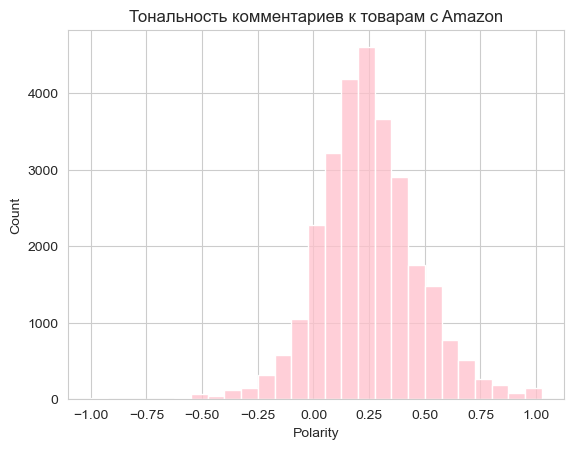

In [17]:
plot = sns.histplot(data["Polarity"], binwidth=0.075, color='pink')

# Не забываем про заголовок
plot.set_title('Тональность комментариев к товарам с Amazon') 

# И сохраняем наш график
plot.figure.savefig("polarity.png")

Аналогично вы можете построить график для субъективности. 

В наших данных есть еще один интересный признак — `Score`, то есть оценка товара. Давайте посмотрим среднюю тональность для каждой оценки. 

Чтобы наш код был более универсален, обратимся к каждому уникальному значению в столбце `Score`, использовав метод `.unique()`. Мы знаем, что там всего пять значений (1-5), но вдруг вы будете работать с данными, где их больше.

In [18]:
for score in data['Score'].unique():
    print(score)

2
5
4
3
1


Видим, что они могут идти не по порядку, поэтому используем функцию `sorted()`, чтобы гарантированно получить оценки от наименьшей к наибольшей. 

Если же вы хотите, наоборот, вывести оценки от наибольшей к наименьшей, то в функцию `sorted()` необходимо добавить параметр `reverse` и присвоить ему значение `True`.

In [19]:
for score in sorted(data['Score'].unique()):
    print(f'Оценка {score}')

Оценка 1
Оценка 2
Оценка 3
Оценка 4
Оценка 5


Далее ищем среднее значение тональности только, например, для оценки 1. 

1. Сначала фильтруем наши данные и указываем, что нас интересуют только те, где столбец `Score` принимает значение 1: `data[data['Score'] == 1]`.
2. Затем забираем из данных только столбец `Polarity`.
3. И к нему применяем метод `.mean()`.

In [20]:
print(data[data['Score'] == 1]['Polarity'].mean())

0.0059045282267595435


Видим, что тональность для товаров, оценненых на 1, очень низкая. Теперь вместо 1 нужно подставить остальные оценки, это можно сделать в цикле.

In [21]:
for score in sorted(data['Score'].unique()):
    print(f'Оценка {score}')
    print(data[data['Score'] == score]['Polarity'].mean())

Оценка 1
0.0059045282267595435
Оценка 2
0.07935445819809125
Оценка 3
0.15152302207663432
Оценка 4
0.23756491110136208
Оценка 5
0.30193765848631404


Визуализируем результат! Используем функцию `barplot()`, также из модуля `seaborn`. В ней установим цвет, а также укажем параметр `errorbar` — присвоим ему значение `None`. Сам параметр задуман, чтобы показывать отклонения в данных, ошибки; по умолчанию он принимает значение `('ci', 95)` (доверительный интервал 95%), однако можно перенастроить его вручную, о чем подробно написано в официальной [документации](https://seaborn.pydata.org/tutorial/error_bars.html).

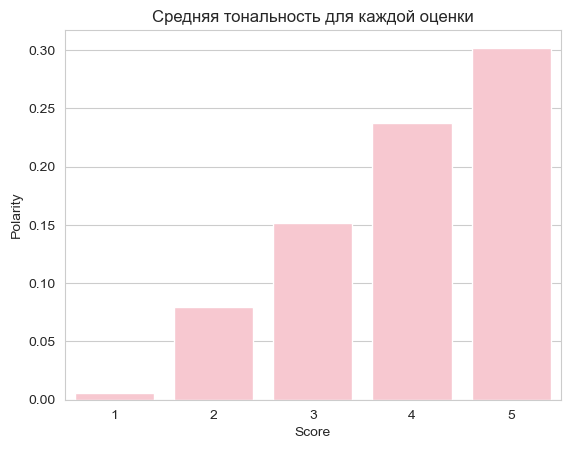

In [22]:
plot = sns.barplot(data=data, x='Score', y='Polarity', errorbar=None, color='pink')

# Не забываем про заголовок
plot.set_title('Средняя тональность для каждой оценки') 

# И сохраняем наш график
plot.figure.savefig("polarity_and_score.png")

Видим, что все логично — чем выше оценка, тем выше средняя тональность. Но если бы мы получили другой график, то следовало бы задуматься над результатами. 

На этом пока остановимся на анализе англоязычного контента и посмотрим, что же делать с русскими текстами.

## Работа с русскоязычными текстами

Как уже было сказано, представленные выше способы не работают с русскоязычными текстами. 

Нам понадобится импортировать `RegexTokenizer()` и `FastTextSocialNetworkModel()` из модуля `dostoevsky`. 

In [23]:
#!pip install dostoevsky
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

Сразу их инициализируем. Нам будет выдано небольшое предупреждение, но оно никак не помешает дальнейшей работе. 

In [24]:
tokenizer = RegexTokenizer()
dostoevsky_model = FastTextSocialNetworkModel(tokenizer=tokenizer)

При первом запуске может возникнуть ошибка `ValueError: <...> data/models/fasttext-social-network-model.bin cannot be opened for loading!`. Она решается непосредственным скачиванием файла [отсюда](https://storage.b-labs.pro/models/fasttext-social-network-model.bin) — после скачивания его нужно переместить в папку, путь к которой указан в ошибке.

Попробуем проверить слово "хорошо". 

In [25]:
print(dostoevsky_model.predict('хорошо'))

[{'neutral': 1.0000100135803223, 'skip': 0.001335022272542119, 'negative': 1.0000003385357559e-05, 'speech': 1.0000003385357559e-05, 'positive': 1.0000003385357559e-05}, {'neutral': 1.0000100135803223, 'skip': 1.0000003385357559e-05, 'negative': 1.0000003385357559e-05, 'speech': 1.0000003385357559e-05, 'positive': 1.0000003385357559e-05}, {'neutral': 1.0000100135803223, 'skip': 1.0000003385357559e-05, 'negative': 1.0000003385357559e-05, 'speech': 1.0000003385357559e-05, 'positive': 1.0000003385357559e-05}, {'neutral': 1.0000100135803223, 'skip': 1.0000003385357559e-05, 'negative': 1.0000003385357559e-05, 'speech': 1.0000003385357559e-05, 'positive': 1.0000003385357559e-05}, {'neutral': 1.0000100135803223, 'skip': 0.006498271133750677, 'negative': 1.0000003385357559e-05, 'speech': 1.0000003385357559e-05, 'positive': 1.0000003385357559e-05}, {'neutral': 1.0000100135803223, 'skip': 1.0000003385357559e-05, 'negative': 1.0000003385357559e-05, 'speech': 1.0000003385357559e-05, 'positive': 1.

Результат получился очень странным — слишком уж много всего. На самом деле команда работает с итерируемыми объектами. В нашем случае она нашла метрики для каждой буквы слова "хорошо". Попробуем передать аргумент в виде списка из одного элемента.

In [26]:
print(dostoevsky_model.predict(['хорошо'])) # Все работает!

[{'positive': 0.9989450573921204, 'skip': 0.0006562031921930611, 'negative': 1.0000003385357559e-05, 'speech': 1.0000003385357559e-05, 'neutral': 1.0000003385357559e-05}]


Смотрим, что нам выдано (на самом деле, очень похоже на `vader`): 
    
+ `positive / negative` — насколько текст позитивный / негативный соответственно;
+ `neutral` — нейтральность текста;
+ `skip` — "шум", либо что-то сложное для определения;
+ `speech` — обычная речь (например, приветствие).

Обратите внимание на порядок ключей получившегося словаря — они идут от наиболее вероятного к наименее (в нашем случае слово скорее всего позитивное, и только потом его можно принять за "шум").

Посмотрим еще один пример — ключи словаря будут уже в другом порядке. Также можно дополнительно указать параметр `k`, которые определяет количество ключей, которые будут показаны.

In [27]:
print(dostoevsky_model.predict(['грусть-тоска'])) 
print(dostoevsky_model.predict(['грусть-тоска'], k=2)) 

[{'negative': 0.23935934901237488, 'skip': 0.061885979026556015, 'neutral': 0.02596735954284668, 'positive': 0.0032830648124217987, 'speech': 1.0000003385357559e-05}]
[{'negative': 0.23935934901237488, 'skip': 0.061885979026556015}]


И, наконец, разберем, как же будут проанализированы комментарии из книги отзывов ресторана. 

In [28]:
reviews = [
    'Мне очень понравилось в вашем ресторане, уверен, что еще загляну! Ах, какие мидии!',
    'Здесь достаточно уютно, однако я бывал и в местах получше',
    'Просто отвратительно! Никогда сюда больше не зайду'
]

print(dostoevsky_model.predict(reviews)) 

[{'positive': 0.5775054097175598, 'neutral': 0.10375863313674927, 'negative': 0.0695517510175705, 'skip': 0.04337579756975174, 'speech': 0.031153826043009758}, {'neutral': 0.8221991658210754, 'positive': 0.29422497749328613, 'negative': 0.051855459809303284, 'skip': 0.0191340371966362, 'speech': 1.0000003385357559e-05}, {'negative': 0.7663036584854126, 'skip': 0.11280541121959686, 'neutral': 0.09535945951938629, 'positive': 0.09010298550128937, 'speech': 0.0061075626872479916}]


Оно работает, но в таком виде результаты не очень читаемы. Давайте попробуем преобразовать выдачу с помощью цикла.

Объединим наши отзывы и результат предсказания в один словарь с помощью функций `zip()` и `dict()`, далее обратимся к методу `.items()` — он выдаст нам пары ключ-значение (отзыв-словарь с результатом).

In [29]:
for review, data in dict(zip(reviews, dostoevsky_model.predict(reviews, k=1))).items():
    print(f'Отзыв: {review}')
    print(f'Результат: {data}')

Отзыв: Мне очень понравилось в вашем ресторане, уверен, что еще загляну! Ах, какие мидии!
Результат: {'positive': 0.5775054097175598}
Отзыв: Здесь достаточно уютно, однако я бывал и в местах получше
Результат: {'neutral': 0.8221991658210754}
Отзыв: Просто отвратительно! Никогда сюда больше не зайду
Результат: {'negative': 0.7663036584854126}


Видим, что работает достаточно неплохо. 

Это лишь небольшой пример того, как определить тональность русскоязычного текста. В следующих темах мы научимся атоматически собирать комментарии (например, из VK) и применим к их анализу знания, которые получили сегодня!